<a name = "title"></a>
## Введение

Одна из самых больших проблем в финансах - это прогнозирование цен на акции. Однако с
с появлением последних достижений в сферах машинного обучения, эта область развилась достадочно чтобы использовать недетерминированные(стохастические?) решения, которые узнают, что происходит для получения более точных прогнозов.
Методы машинного обучения, позволяют прогнозировать курс акций на основе исторических данных (временных рядов).
Прогнозы могут быть сделаны на один временной промежуток вперед или на определенный интервал.

В качестве общего обзора, помимо исторической цены самой акции, функции
которые обычно полезны для прогнозирования курса акций:

 - Коррелированные активы  
     Организация зависит от многих внешних факторов и взаимодействует с ними, в том числе:
     конкуренты, клиенты, мировая экономика, геополитическая ситуация, фискальная и
     денежно-кредитная политика, доступ к капиталу и так далее. Следовательно, цена его акций может быть коррелирована
     не только с курсом акций других компаний, но и с другими
     активы, такие как сырьевые товары, иностранная валюта, общие индексы или даже фиксированный доход
     ценные бумаги.
 - Технические индикаторы  
    Многие инвесторы следят за техническими индикаторами. Скользящее среднее, экспоненциальное скользящее
    средний и импульс - самые популярные индикаторы.
 - Фундаментальный анализ  
    Два основных источника данных для определения функций, которые можно использовать в фундаментальных
    анализ включает:
    - Отчеты о производительности
        Годовые и квартальные отчеты компаний могут использоваться для извлечения или определения
        ключевые показатели, такие как ROE (рентабельность капитала) и P / E (отношение цены к капиталу).
        Заработок).
    - Новости  
        Новости могут указывать на предстоящие события, которые потенциально могут изменить курс акций.
        в определенном направлении.
В этом тематическом исследовании мы будем использовать различные модели, основанные на контролируемом обучении, 
для прогнозирования цен акций Microsoft с использованием коррелированных активов и собственных исторических данных

- ROE (Return on Equity)
- P/E (Price-to-Earnings)


<a name = "contents"></a>
## Содержание

* [1. Описание проблемы](#0)
    * [1.1. Импорт необходимых библиотек](#1.1)    
    * [1.2. Загрузка данных](#1.2)
* [2. Иследовательский анализ данных](#2)
    * [2.1 Описательная статистика](#2.1)    
    * [2.2.Анализ временного ряда](#2.2)
* [3. подготовка данных](#3) 
* [4.Сравнение моделей](#4) 
    * [4.1 Разделение на тестовую и тренировочную выборку](#4.1)
    * [4.2 Линейные модели](#4.2)
    * [4.3 модель ARIMA](#4.3)
* [5. Вывод](#5)
     

<a id='0'></a>

# 1. Описание проблемы

Пример использования различных моделей обучения с учителем для прогнозирования курса акции Microsoft с использованием коррелированных активов и собственных исторических данных.

Зависимотси будем искать в значениях:
* Stocks: IBM (IBM), Alphabet (GOOGL) + 200 акции из технологических сфер
* Currency: USD/JPY and GBP/USD
* Indices: S&P 500, Dow Jones and VIX

[Содержание](#contents)

<a name = '1.1'></a>

## 1.1 Импорт необходимых библиотек

[Содержание](#contents)

In [1]:
# Библиотеки для обработки массивов данных 
import numpy as np
import pandas as pd
#Импорт данных по трейдовым биржам как Google, Yahoo! Finance или Всемирный банк 
import pandas_datareader.data as web
#Пакеты для визуализации
import seaborn as sns
import matplotlib.pyplot as plt  
from pandas.plotting import scatter_matrix
plt.style.use('ggplot')

#Разделение данных 
from sklearn.model_selection import train_test_split
#Кросс валидация по фолдам (для избежания переобучения)
from sklearn.model_selection import KFold
# Кросс валидация 
from sklearn.model_selection import cross_val_score
# Подбор гиперрпараметров
from sklearn.model_selection import GridSearchCV

#Модели
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet

# Оценка ошибки
from sklearn.metrics import mean_squared_error


#инструмент со статистикой
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import ARMA, adfuller


# подбор гиперпараметров **
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression


#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

<a name = "1.2"></a>
## 1.2 Загрузка данных

Данные берутся с:

- Yahoo Finance - https://finance.yahoo.com/
- FRED - https://fred.stlouisfed.org/

[Содержание](#contents)

Определяем зависимую и независимые пременные

- Y:
    - MSFT **Прогнозируемые** заначения
    

- X:
    - GOOGL значения за 5 дней 
    - IBM значения за 5 дней
    - Nvidia значения за 5 дней
    - Apple значения за 5 дней
    - Intel значения за 5 дней
    - ^IXIC(NASDAQ) значения за 5 дней
    - USD/JPY значения за 5 дней  
    - GBP/USD значения за 5 дней   
    - S&P 500 значения за 5 дней   
    - Dow Jones значения за 5 дней    
    - MSFT значения за 5 дней    
    - MSFT значения за 15 дней    
    - MSFT значения за 30 дней   
    - MSFT значения за 60 дней


- Adj Close - это «отрегулированная» цена закрытия (adjusted closing price), это значит, что в цену закрытия периода были добавлены все действия с акциями, которые могли быть совершены до момента открытия следующего торгового дня.

- Volume -  количество акций, с которыми совершались сделки в торговый день.

In [2]:
st_list= pd.read_excel('technology_stocks.xlsx').iloc[:,0].to_list()
'MSFT' in st_list


False

In [3]:
stk_tickers = ['MSFT']+ st_list
#изменения курсов валют Японии/США и Америки/Великобритании
ccy_tickers = ['JPY=X', 'EURUSD=X','GBPUSD=X']
# индексы Доу джонсона SP500 и VIXCLS
idx_tickers = ['SP500', 'DJIA', 'VIXCLS','NASDAQCOM','NASDAQ100']

#https://finance.yahoo.com/
stk_data = web.DataReader(stk_tickers,'yahoo')

# https://fred.stlouisfed.org/
# курсы валют
ccy_data = web.DataReader(ccy_tickers, 'yahoo')
# индексы
idx_data = web.DataReader(idx_tickers, 'fred')

In [25]:
stk_data = stk_data[stk_data>1].dropna(axis = 1)

### Таблица загруженных значений акции:

In [10]:
stk_data['Adj Close']

Symbols,MSFT,AACAY,AAPL,ACKAY,ACN,ADI,ADTN,AEXAY,ALOT,AMADY,...,MPWR,MRAAF,MRVL,VSH,WCRS,WDC,WIRE,WIT,WSO,WSTG
Date,,,,,,,,,,,,,,,,,,,,,
2016-05-24,47.527714,7.119694,22.864182,28.059559,109.615173,52.340958,16.859665,16.850925,13.418583,42.003025,...,63.823093,105.080986,9.432186,11.693085,4.299043,36.869251,37.984295,5.906528,111.391151,13.549015
2016-05-25,48.015968,7.126081,23.265877,28.059559,109.090645,52.766579,16.788939,16.934254,13.881292,41.835648,...,63.823093,106.017944,9.479300,11.464524,4.299043,38.499943,38.400826,5.965593,111.610596,13.533055
2016-05-26,47.804081,6.889762,23.450378,27.920042,108.961823,52.784679,16.939234,17.142572,13.881292,42.839924,...,64.748627,102.738548,9.564104,11.583375,4.299043,38.700508,37.785938,5.970515,111.787849,13.684666
2016-05-27,48.200222,6.898887,23.436363,27.386589,109.449524,52.920509,16.983440,17.043093,13.612920,42.328487,...,65.378365,106.533272,9.488722,11.747940,3.654186,39.232452,38.291737,5.990204,112.648720,13.716585
2016-05-31,48.826679,7.388861,23.321924,26.984451,109.477127,52.974850,17.195618,17.141634,13.363055,43.063099,...,65.197067,108.454056,9.639485,11.848504,3.654186,40.584087,38.668594,5.911450,113.290146,13.668707
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-18,242.520004,5.730000,124.849998,19.340000,283.010010,145.889999,19.430000,13.350000,15.740000,73.269997,...,309.399994,75.400002,42.450001,23.330000,7.774035,73.209999,81.410004,7.450000,288.690002,25.020000
2021-05-19,243.119995,5.700000,124.690002,19.340000,280.970001,153.119995,19.510000,13.210000,15.920000,71.779999,...,319.799988,72.949997,44.509998,23.639999,7.485000,71.260002,80.400002,7.470000,282.519989,25.010000
2021-05-20,246.479996,5.750000,127.309998,19.670000,283.950012,159.470001,19.809999,13.405000,16.180000,73.139999,...,331.970001,76.105003,46.259998,23.889999,7.200000,72.949997,80.459999,7.560000,284.320007,25.660000


**Дифференцирование** - это метод преобразования набора данных временного ряда. Его можно использовать для устранения зависимости ряда от времени, так называемой временной зависимости. Это включает в себя такие структуры, как тенденции и сезонность. Применяется через функцию diff()  

In [32]:
# период запаздывания и дифференциорования
return_period = 5
#Shift циклический сдвигает на 5 элементов ()
#diff  понижет размерность на 5 отнимая от n элемента (n-5)
#берем фиксированную цену закрытия акции MSFT
# Пуем логарифмирования получаем более симетричное распределение значений вокруг нуля (предобработка)
# отнимаем значение от значения 5 дней назад(diff) и сдивагаем данные на 5 дней вниз(shift)
# тут идут данные для обучения путем shift смещаем значения на неделю назад т.к. это предсказываемые значения
# diff показывет тенденцию (изменение) стоймости по сравению с предыдущей неделей
Y = np.log(stk_data.loc[:, ('Adj Close', stk_tickers[0])]).diff(return_period).shift(-return_period)
# переименовывем название стольбца
Y.name = Y.name[-1]+'_pred'

#логарифмируем значения и отнимаем значения от значении 5 дней назад(diff) *находим тендецию
X1 = np.log(stk_data.loc[:, ('Adj Close', ( stk_tickers[1:]))]).diff(return_period) 
## коректируем шапку таблицы
X1.columns = X1.columns.droplevel()
X2 = np.log(ccy_data['Adj Close']).diff(return_period)
X3 = np.log(idx_data).diff(return_period)
# добавлям столбцы изменения за 5 15 30 60 дней   
X4 = pd.concat([np.log(stk_data.loc[:, ('Adj Close', stk_tickers[0])]).diff(i) for i in [return_period, return_period*3,
                                                                    return_period*6, return_period*12]], axis=1).dropna()
X4.columns = [stk_tickers[0] + '_DT',stk_tickers[0] + '_3DT', stk_tickers[0] + '_6DT', stk_tickers[0] + '_12DT']
X = pd.concat([X1, X2, X3, X4], axis=1)
# обьеденяем все значения в новую таблицу dataset 
# ставим итерацию на период предсказания в данном случае получучаем одно значения каждую неделю
dataset = pd.concat([Y, X], axis=1).dropna().iloc[::return_period, :]
# разделяем значения
#dataset = dataset[(dataset.index.year>=2018)]
Y = dataset.loc[:, Y.name]
X = dataset.loc[:, X.columns]

##  Какой вид приняли наши значения:

In [33]:
dataset.tail()

,MSFT_pred,AACAF,AACAY,AAPL,ACKAY,ACN,ADI,ADTN,ADTTF,AEXAY,...,GBPUSD=X,SP500,DJIA,VIXCLS,NASDAQCOM,NASDAQ100,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT
2021-04-08,0.024380,-0.011881,0.017665,0.065050,0.040075,0.029146,0.044396,0.100854,0.000000,-0.102130,...,-0.007306,0.019047,0.010512,-0.022171,0.025575,0.031676,0.071520,0.066148,0.076708,0.154525
2021-04-19,0.010802,0.000000,0.013537,0.027061,-0.006012,-0.000394,-0.017812,-0.041135,0.000000,0.032058,...,0.017300,0.008508,0.009797,0.022223,0.004666,0.006371,0.010998,0.089960,0.110812,0.142157
2021-04-27,-0.055648,0.000000,-0.029853,0.009570,-0.044615,0.005701,0.032357,0.017801,0.675969,0.002178,...,-0.002534,0.012445,0.004826,-0.061830,0.021808,0.010874,0.014263,0.055366,0.109453,0.123966
2021-05-05,-0.030777,0.000000,-0.027299,-0.041889,-0.023404,-0.002587,-0.013743,-0.021765,0.000000,-0.024564,...,-0.003372,-0.003734,0.012049,0.102753,-0.033919,-0.029066,-0.032296,-0.036334,0.036736,0.018663
2021-05-13,0.016402,0.000000,-0.031689,-0.035762,-0.019535,-0.020262,-0.058219,0.077635,0.000000,0.013121,...,0.010900,-0.021439,-0.015374,0.229323,-0.037964,-0.037768,-0.027195,-0.056553,0.030328,-0.004803


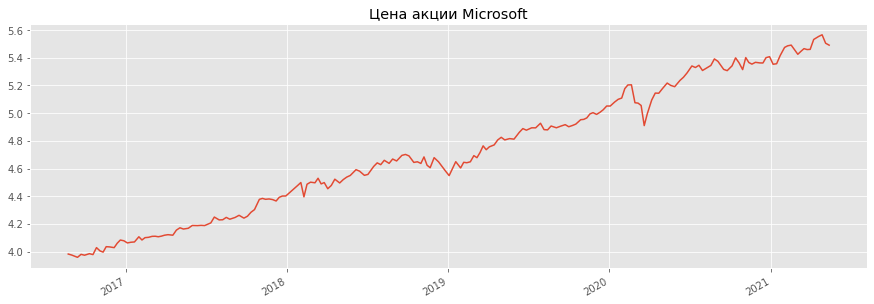

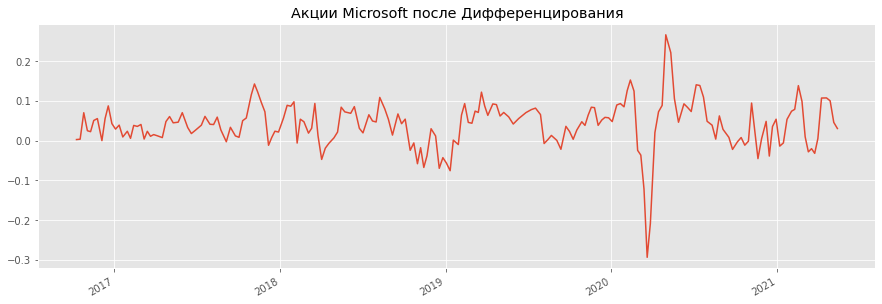

In [37]:
np.log(stk_data.loc[:, ('Adj Close', 'MSFT')][Y.index]).plot(figsize = (15,5),title = "Цена акции Microsoft");
plt.show();
np.log(stk_data.loc[:, ('Adj Close', 'MSFT')][Y.index]).diff(return_period).plot(figsize = (15,5),
                                                                        title = "Акции Microsoft после Дифференцирования");

<a name = "2"></a>
## 2. Иследовательский анализ данных
[содержание](#contents)

In [39]:
#Для большей наглядности возьмем выборку
example = ['MSFT_pred','IBM','NVDA','JPY=X', 'EURUSD=X','GBPUSD=X','SP500', 'DJIA', 'VIXCLS','NASDAQ100']
# формат вывода 3 значения после запятой
pd.set_option('precision', 3)
dataset.describe()

,MSFT_pred,AACAF,AACAY,AAPL,ACKAY,ACN,ADI,ADTN,ADTTF,AEXAY,...,GBPUSD=X,SP500,DJIA,VIXCLS,NASDAQCOM,NASDAQ100,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT
count,205.000,205.000,205.000,205.000,2.050e+02,205.000,205.000,205.000,205.000,2.050e+02,...,2.050e+02,205.000,205.000,205.000,205.000,205.000,205.000,205.000,205.000,205.000
mean,0.006,-0.002,-0.003,0.006,-2.545e-04,0.004,0.004,0.002,0.011,-1.274e-03,...,-4.543e-05,0.003,0.003,0.003,0.004,0.005,0.006,0.020,0.038,0.080
std,0.033,0.076,0.065,0.040,6.574e-02,0.031,0.037,0.065,0.097,5.966e-02,...,1.354e-02,0.026,0.029,0.171,0.028,0.028,0.032,0.050,0.058,0.068
min,-0.153,-0.218,-0.199,-0.193,-3.673e-01,-0.160,-0.159,-0.262,-0.321,-3.488e-01,...,-8.947e-02,-0.162,-0.190,-0.559,-0.135,-0.134,-0.145,-0.165,-0.288,-0.137
25%,-0.010,-0.037,-0.042,-0.015,-3.061e-02,-0.007,-0.016,-0.025,0.000,-1.972e-02,...,-7.626e-03,-0.004,-0.004,-0.089,-0.009,-0.009,-0.012,-0.003,0.008,0.045
50%,0.008,0.000,-0.001,0.008,0.000e+00,0.005,0.004,0.002,0.000,9.406e-04,...,-1.119e-04,0.005,0.005,-0.008,0.006,0.007,0.007,0.020,0.043,0.082
75%,0.026,0.033,0.039,0.029,3.624e-02,0.020,0.028,0.029,0.000,2.781e-02,...,7.821e-03,0.014,0.014,0.074,0.019,0.019,0.024,0.048,0.075,0.123
max,0.091,0.354,0.196,0.119,1.742e-01,0.083,0.096,0.328,0.768,3.504e-01,...,5.963e-02,0.098,0.121,0.910,0.087,0.082,0.091,0.245,0.244,0.359


<a name = "2.1"></a>
## 2.1 Описательная статистика
Гистограмма распределения
[содержание](#contents)

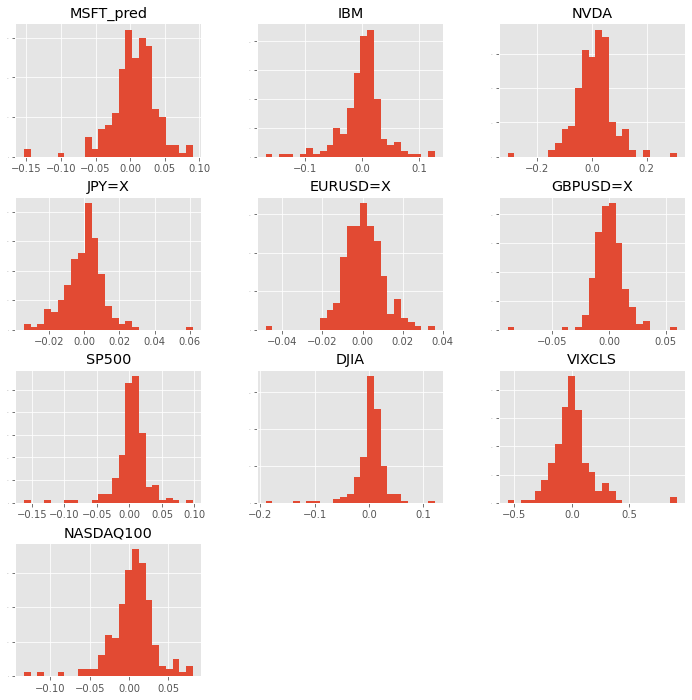

In [40]:
dataset[example].hist(bins=25, sharex=False, sharey=False, ylabelsize=1, figsize=(12,12))
plt.show()

<AxesSubplot:title={'center':'Матрица корреляции'}>

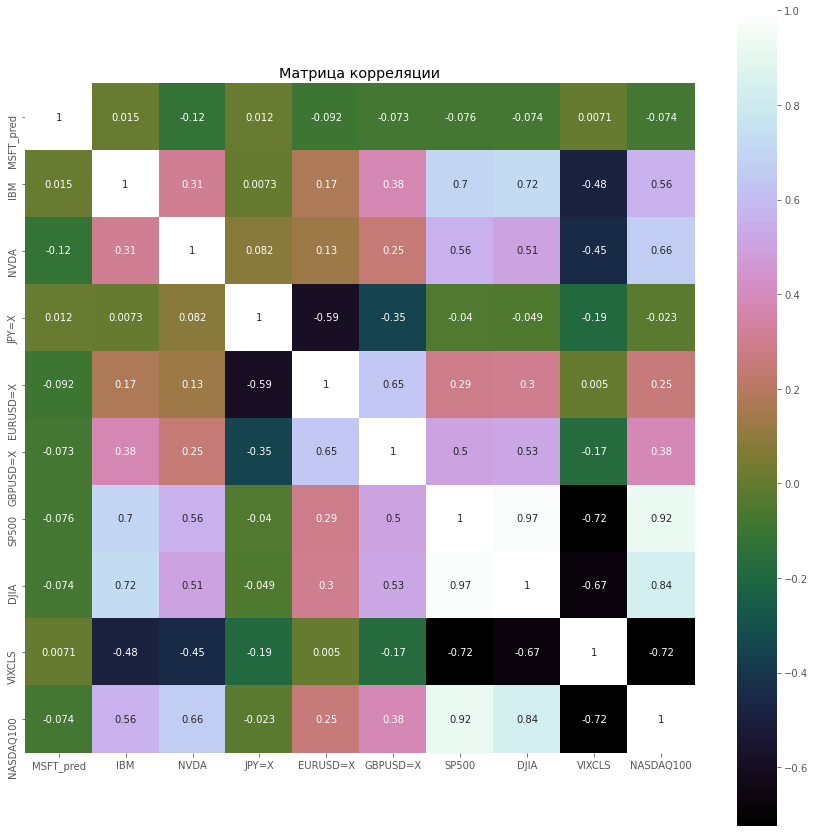

In [41]:
correlation = dataset[example].corr()
plt.figure(figsize=(15,15))
plt.title('Матрица корреляции')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

<Figure size 1080x1080 with 0 Axes>

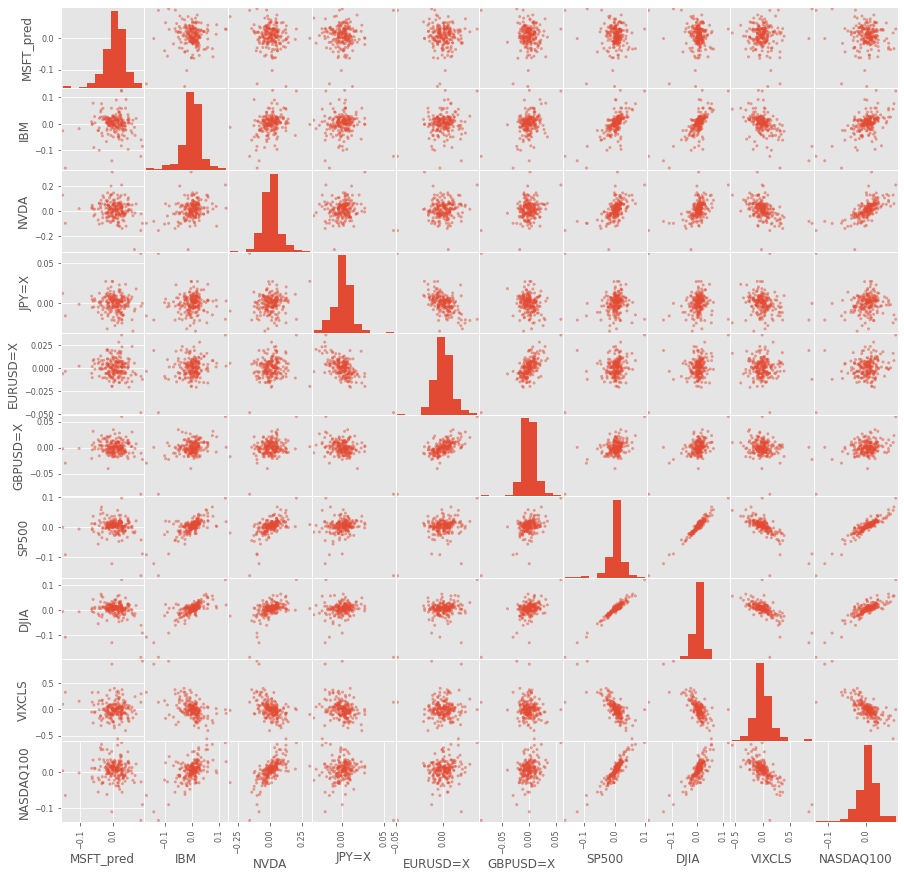

In [42]:
plt.figure(figsize=(15,15))
scatter_matrix(dataset[example],figsize=(15,15))
plt.show()

<a name = "2.2"></a>
## 2.2 Анализ временного ряда

[содержание](#contents)

## Компоненты временного ряда
Полезной абстракцией для выбора методов прогнозирования является разбиение временного ряда на систематические и несистематические компоненты.

- **систематическая**: Компоненты временного ряда, которые имеют последовательность или повторяемость и могут быть описаны и смоделированы.
- **Несистематический**: Компоненты временного ряда, которые не могут быть смоделированы напрямую.
Считается, что данный временной ряд состоит из трех систематических компонентов, включая уровень, тренд, сезонность, и одного несистематического компонента, называемого шумом.

Эти компоненты определены следующим образом:

- уровень: Среднее значение в серии.
- тенденция: Увеличение или уменьшение значения в серии.
- Сезонность: Повторяющийся краткосрочный цикл в серии.
- Шум: Случайное изменение в ряду.

##  Аддитивная модель
Аддитивная модель предполагает, что компоненты добавляются вместе следующим образом:

$$y(t) = Level + Trend + Seasonality + Noise$$
Аддитивная модель является линейной, где изменения во времени последовательно вносятся в одну и ту же величину.

Линейный тренд - это прямая линия.

Линейная сезонность имеет одинаковую частоту (ширина циклов) и амплитуду (высота циклов).

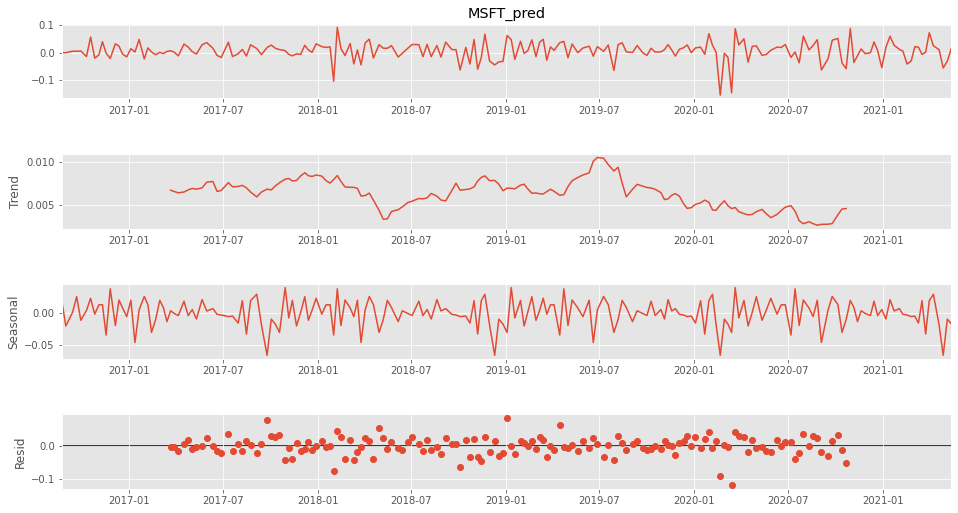

In [43]:
# freq=52 период 52 - количество недель в году
res = sm.tsa.seasonal_decompose(Y,model='additive',freq=52)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

## тест Дики Фуллера

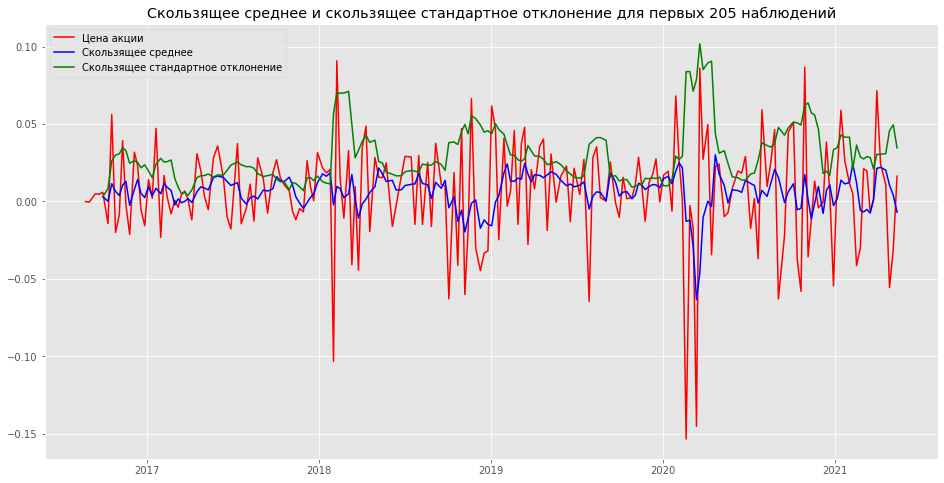

Test Statistic                 -12.780
p-value                          0.000
#Lags Used                       1.000
Number of Observations Used    203.000
Critical Value (1%)             -3.463
Critical Value (5%)             -2.876
Critical Value (10%)            -2.574
dtype: float64


In [44]:
def stationarity(ts, window, n):
    roll_mean = ts.rolling(window).mean()
    roll_std = ts.rolling(window).std()
    
    plt.figure(figsize = (16, 8))
    
    plt.plot(ts[:n], label = 'Цена акции', color = 'red')
    plt.plot(roll_mean[:n], label = 'Скользящее среднее', color = 'blue')
    plt.plot(roll_std[:n], label = 'Скользящее стандартное отклонение', color = 'green')
    plt.title("Скользящее среднее и скользящее стандартное отклонение для первых %d наблюдений"%(n))
    plt.legend(loc = 'best')
    plt.show(block = False)
    
    dftest = adfuller(ts)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(round(dfoutput,5))
    
stationarity(Y,5,len(Y))

Тест показал что ряд стационарен

<a name='3'></a>
## 3.  Подготовка данных
[Содержание](#contents)

Мы используем sklearn's SelectKBest Для проверки статистической значимости и нахождения P-value для значений кореляции

In [129]:
bestfeatures = SelectKBest(k=5, score_func=f_regression)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#Обьедняем значения для визуализации
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Акции','Значимость']  #naming the dataframe columns
featureScores.nlargest(10,'Значимость').set_index('Акции')  #print 10 best features

spc = featureScores.nlargest(100,'Значимость').set_index('Акции').index[:18].values

Для большей точности можно уменьшить выборку до 3 лет тем самым получив более высокоточные и актуальные коэфиценты

In [50]:
y = 2019

bestfeatures = SelectKBest(k=5, score_func=f_regression)
fit = bestfeatures.fit(X[X.index.year >=y],Y[Y.index.year >=y])
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#Обьедняем значения для визуализации
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Акции','Значимость']  #naming the dataframe columns
featureScores.nlargest(10,'Значимость').set_index('Акции')  #print 10 best features

,Значимость
Акции,
AVEVF,13.057
SNEJF,8.024
RSTAY,8.022
FJTSF,7.399
MIXT,6.287
MSFT_6DT,5.630
EUTLF,5.262
OMRNY,4.880
TCTZF,4.594


In [52]:
#Отбираем самые значимые веса
#spc = featureScores.nlargest(100,'Значимость').set_index('Акции').index[:15].values
#spc
#
##Определяем размер тестовой выборки
#validation_size = 0.3
#
## seed = 7
## X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=validation_size, random_state=seed)
#
#train_size = int(len(X[X.index.year>=y]) * (1-validation_size))
#X_train, X_test = X[X.index.year>=y][spc][0:train_size], X[X.index.year>=y][spc][train_size:len(X)]
#Y_train, Y_test = Y[Y.index.year>=y][0:train_size], Y[Y.index.year>=y][train_size:len(X)]

array(['AVEVF', 'SNEJF', 'RSTAY', 'FJTSF', 'MIXT', 'MSFT_6DT', 'EUTLF',
       'OMRNY', 'TCTZF', 'AMADF', 'STX', 'FORTY', 'SNE', 'QADB', 'TCEHY'],
      dtype=object)

<a name='4'></a>
## 4. Сравнение моделей
[Содержание](#contents)

<a name='4.1'></a>
## 4.1. Разделение на тестовую и тренировочную выборку
[Содержание](#contents)

Поскольку мы собираемся использовать временные ряды, мы должны разбить данные не теряя ее структуры.

In [130]:
#Определяем размер тестовой выборки
validation_size = 0.2

# seed = 7
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=validation_size, random_state=seed)

train_size = int(len(X) * (1-validation_size))
X_train, X_test = X[spc][0:train_size], X[spc][train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]

In [131]:
# Количество фолдов для кросс валидации
num_folds = 10
# Для повторняемости результатов
seed = 7
# scikit не поддерживает Среднеквадратичную ошибку  
# Так что для потимизации моделей будет использованна  NMSE а при сравнении MSE чтобы не было путаницы
scoring = 'neg_root_mean_squared_error' 

<a name='4.2'></a>
## 4.2 Линейные модели
[Содержание](#contents)

In [132]:
models = []
models.append(('Linear', LinearRegression()))
models.append(('LASSO', Lasso(alpha = 0.00006)))
models.append(('Ridge', Ridge(alpha = 0.06)))
models.append(('Elastic-net', ElasticNet(alpha = 0.00006,l1_ratio=0.5 )))
#models.append(('K Neighbors', KNeighborsRegressor(n_neighbors=5)))
#models.append(('Decision Tree', DecisionTreeRegressor()))
#models.append(('Support Vector ', SVR()))

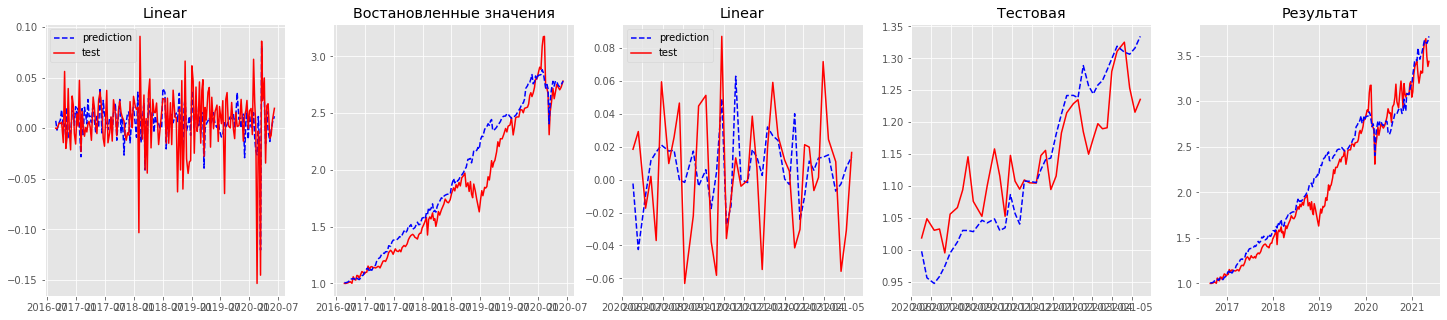

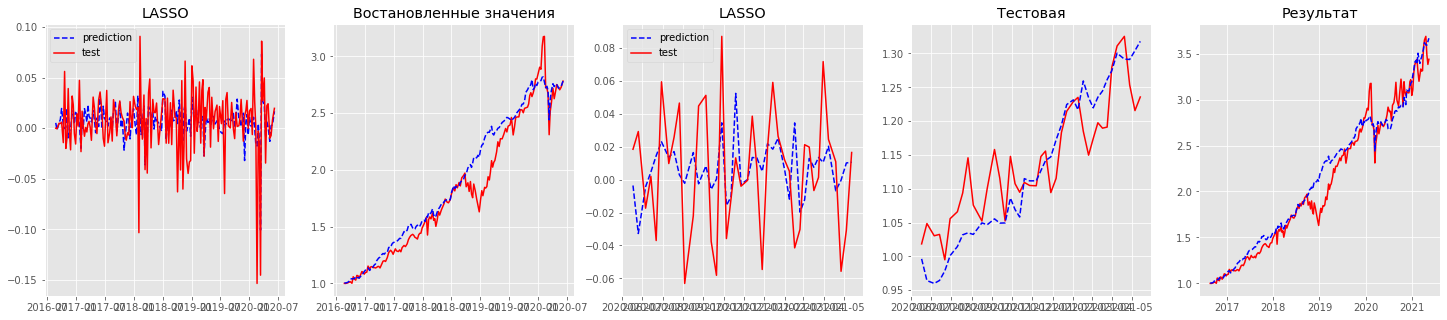

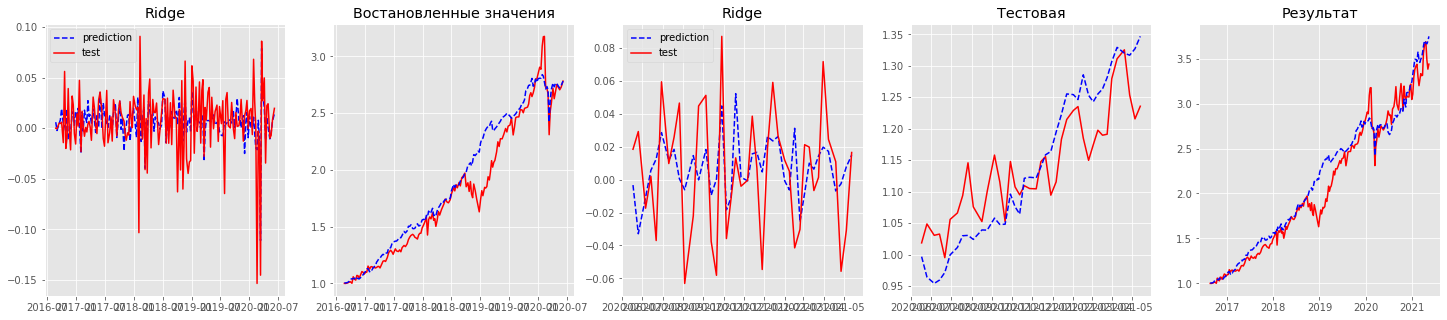

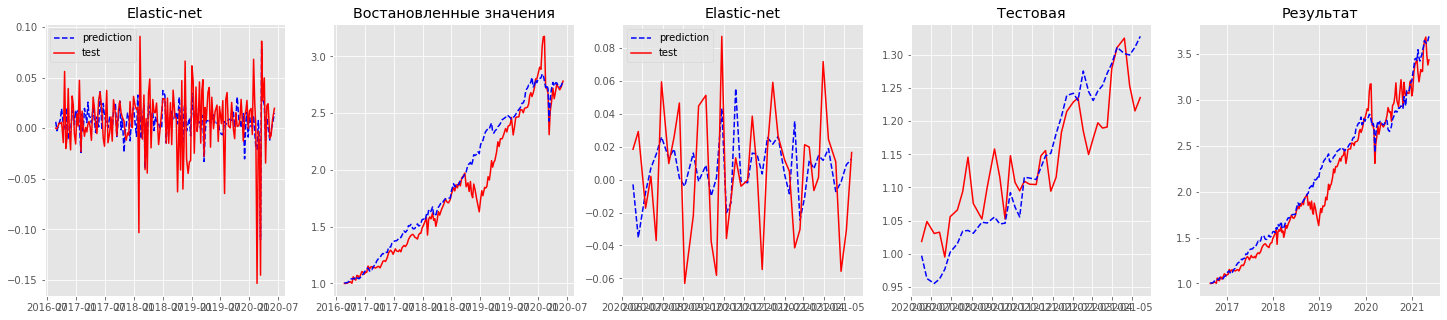

In [133]:
names = []
kfold_results = []
test_results = []
train_results = []
#print("{:<15s} {:<15s} {:<15s} {:<15s} {:<15s}".format("Модель","средняя по ",'std',"тренировочная","тестовая"))
#print("{:<15s} {:<15s} {:<15s} {:<15s} {:<15s}".format("Регрессии","Валидации",'по валидации',"выборка","выборка"))
for name, model in models:
    names.append(name)
    
    ## Валидирую по K фолдам :
    
    kfold = KFold(n_splits=num_folds, random_state=seed)
    #converted mean square error to positive. The lower the beter
    cv_results = -1* cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)
    

    # Full Training period
    res = model.fit(X_train, Y_train)
    train_result = mean_squared_error(res.predict(X_train), Y_train)
    train_results.append(train_result)
    
    # Test results
    test_result = mean_squared_error(res.predict(X_test), Y_test)
    test_results.append(test_result)

    
    #msg = "{:<15s} {:<15f} {:<15f} {:<15f} {:<15f}".format(name, cv_results.mean(), cv_results.std(), train_result, test_result)
   #
    #print(msg)
    
    if 1:
        plt.rcParams["figure.figsize"] = (25,5)
        pred = pd.Series(res.predict(X_train))
        pred.index = Y_train.index
        fig, (ax1, ax2, ax3,ax4,ax5) = plt.subplots(1, 5)
        #fig.figure(figsize = (10,5))
        ax1.title.set_text(name)
        ax1.plot(pred,'b--',label = 'prediction')
        ax1.plot(Y_train,'r',label = 'test')
        ax1.legend()
        #plt.show()
        ax2.title.set_text("Востановленные значения" )
        ax2.plot(np.exp(Y_train).cumprod(), 'r') # plotting t, a separately
        ax2.plot(np.exp(pred).cumprod(), 'b--')
        #ax2.rcParams["figure.figsize"] = (7,4)
        pred_ts = pd.Series(res.predict(X_test))
        pred_ts.index = Y_test.index
        ax3.title.set_text(name)
        ax3.plot(pred_ts,'b--',label = 'prediction')
        ax3.plot(Y_test,'r',label = 'test')
        ax3.legend()

        ax4.title.set_text("Тестовая" )
        ax4.plot(np.exp(Y_test).cumprod(), 'r') # plotting t, a separately
        ax4.plot(np.exp(pred_ts).cumprod(), 'b--')

        pred_f = pd.Series(np.append(res.predict(X_train),(res.predict(X_test))))
        pred_f.index = pd.concat([Y_train,Y_test],axis = 0).index

        ax5.title.set_text("Результат" )
        ax5.plot(np.exp(pd.concat([Y_train,Y_test],axis = 0)).cumprod(), 'r') # plotting t, a separately
        ax5.plot(np.exp(pred_f).cumprod(), 'b--')
        ax5

        plt.show()

Какие акции оказались самыми значимыми?   
выведем топ 5:

In [174]:
model =Lasso(alpha = 0.00006)
res = model.fit(X_train, Y_train)
pd.DataFrame(index = X[spc].columns.values,data = np.abs(res.coef_)).sort_values(by = 0,ascending = False).head(5)

,0
EUTLF,0.198
AMADF,0.097
AVEVF,0.092
MIXT,0.063
MSFT_6DT,0.047


Смотрим результаты Валидации


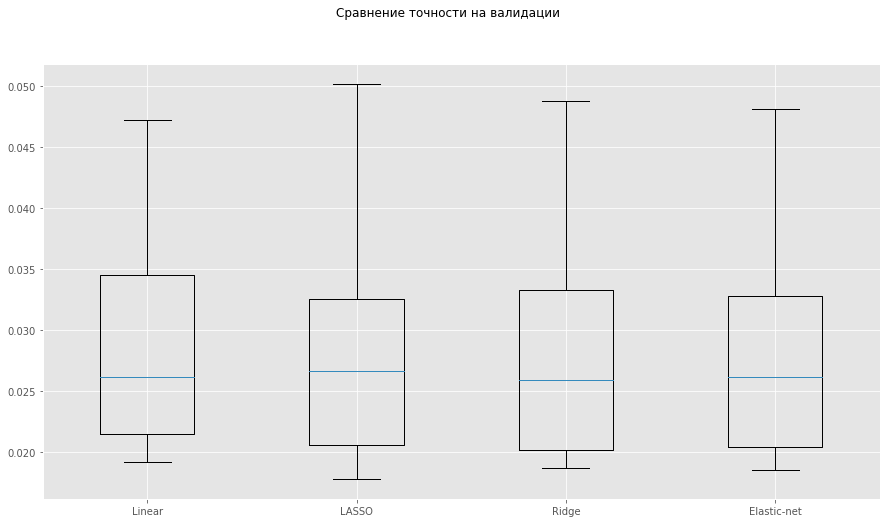

In [134]:
fig = plt.figure()
fig.suptitle('Сравнение точности на валидации')
ax = fig.add_subplot(111)
plt.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
plt.show()

Мы видим, что линейная регрессия и регуляризованная регрессия, включая регрессию Лассо (LASSO) и эластичную сеть (EN), по-видимому, работают хорошо.

### Тестовая выборка

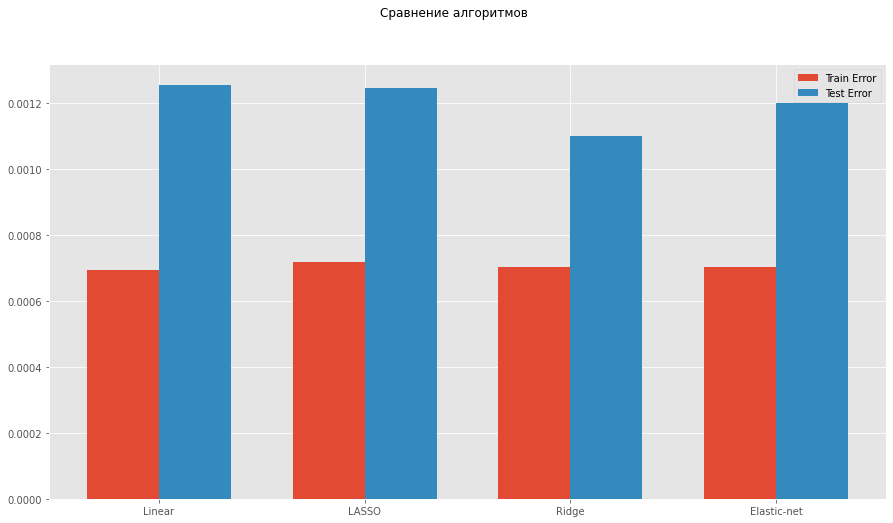

In [135]:
# compare algorithms
fig = plt.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Сравнение алгоритмов')
ax = fig.add_subplot(111)
plt.bar(ind - width/2, train_results,  width=width, label='Train Error')
plt.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
plt.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
plt.show()

<a name='4.3'></a>
## 4.3 модель ARIMA
[Содержание](#contents)

### Для автоматизации процесса будем подбирать параметры авторегрессии и скользящего среднего в цикле

In [137]:
X_train_ARIMA=X_train
X_test_ARIMA=X_test
tr_len = len(X_train_ARIMA)
te_len = len(X_test_ARIMA)
to_len = len(X)

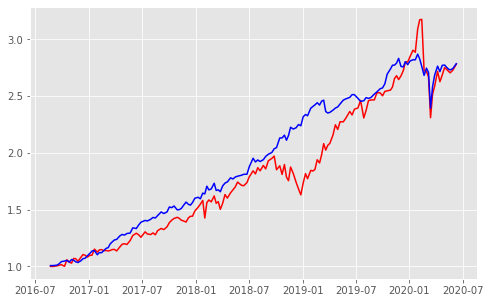

ARIMA(1, 0, 0) MSE=0.0006819


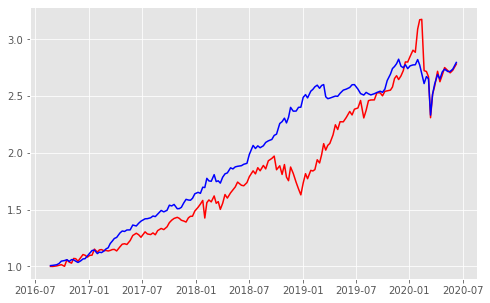

ARIMA(1, 0, 1) MSE=0.0006647


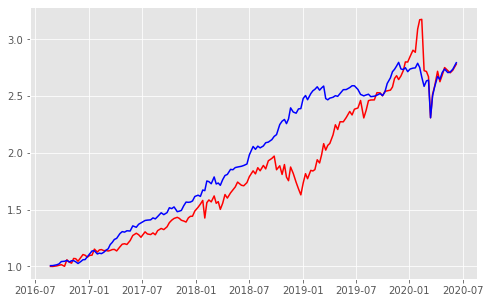

ARIMA(1, 0, 2) MSE=0.0006562


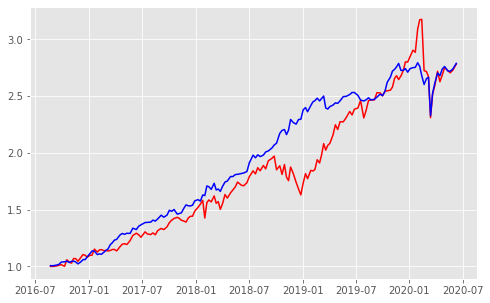

ARIMA(2, 0, 0) MSE=0.0006576


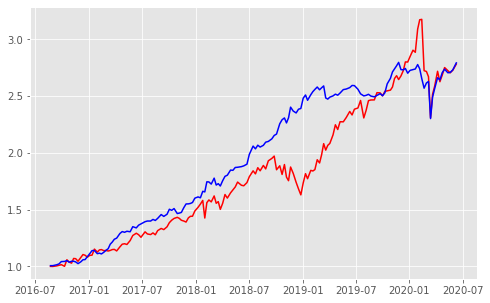

ARIMA(2, 0, 1) MSE=0.0006530


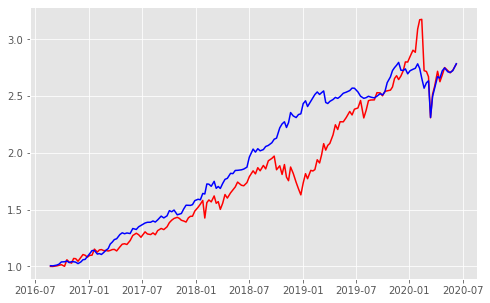

ARIMA(2, 0, 2) MSE=0.0006508


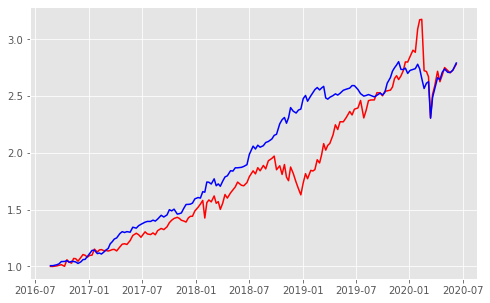

ARIMA(3, 0, 0) MSE=0.0006515


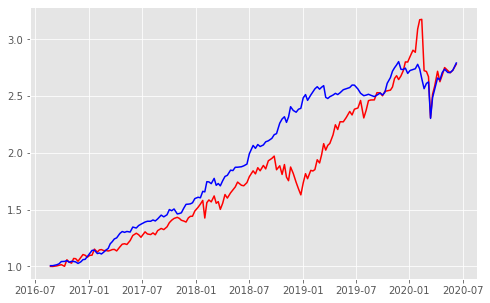

ARIMA(3, 0, 1) MSE=0.0006515


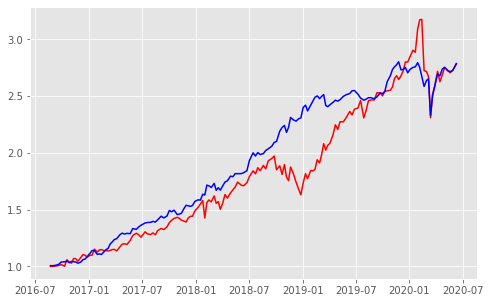

ARIMA(3, 0, 2) MSE=0.0006497


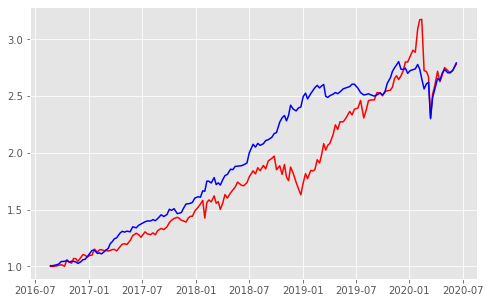

ARIMA(4, 0, 0) MSE=0.0006514


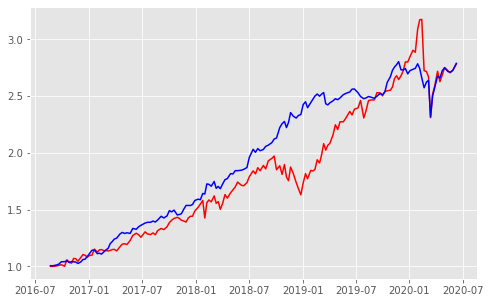

ARIMA(4, 0, 1) MSE=0.0006510


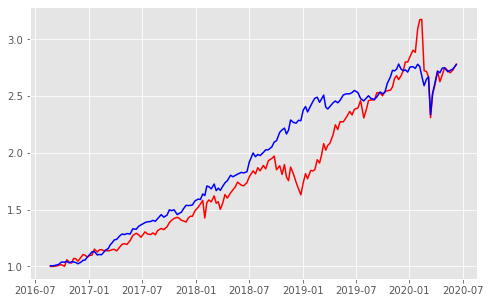

ARIMA(4, 0, 2) MSE=0.0006395
Best ARIMA(4, 0, 2) MSE=0.0006395


In [139]:
#Grid Search for ARIMA Model
#Change p,d and q and check for the best result

# evaluate an ARIMA model for a given order (p,d,q)
#Assuming that the train and Test Data is already defined before
def evaluate_arima_model(arima_order):
    #predicted = list()     
    modelARIMA=ARIMA(endog=Y_train,exog=X_train_ARIMA,order=arima_order)
    model_fit = modelARIMA.fit()
    error = mean_squared_error(Y_train, model_fit.fittedvalues)
    plt.rcParams["figure.figsize"] = (8,5)
    model_fit.fittedvalues.index = Y_train.index

    plt.plot(np.exp(Y_train).cumprod(), 'r') # plotting t, a separately
    plt.plot(np.exp(model_fit.fittedvalues).cumprod(), 'b')
    
    plt.show()
    
    return error

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(p_values, d_values, q_values): 
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)                
                try:
                    mse = evaluate_arima_model(order)                    
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.7f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.7f' % (best_cfg, best_score))
    
# evaluate parameters
p_values = [1,2,3,4]
d_values = range(0,3)
q_values = range(0,3)
warnings.filterwarnings("ignore")
evaluate_models(p_values, d_values, q_values)   

In [140]:
modelARIMA = ARIMA(endog=Y_train,exog=X_train_ARIMA,order=[4,0,2])
model_fit = modelARIMA.fit()

In [141]:
error_Training_ARIMA = mean_squared_error(Y_train[:], model_fit.fittedvalues)
predicted = model_fit.predict(start = tr_len -1 ,end = to_len -1, exog = X_test_ARIMA)[1:]
error_Test_ARIMA = mean_squared_error(Y_test,predicted)
error_Test_ARIMA

0.0015009218330860165

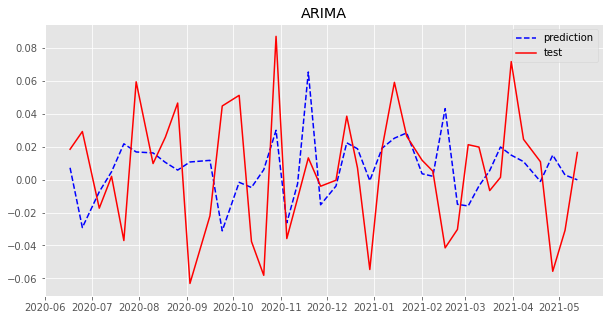

In [142]:
pred = pd.Series(predicted)
pred.index = Y_test.index
plt.figure(figsize = (10,5))
plt.title("ARIMA")
plt.plot(pred,'b--',label = 'prediction')
plt.plot(Y_test,'r',label = 'test')
plt.legend()
plt.show()

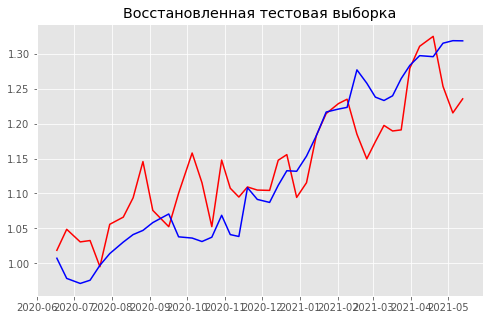

In [149]:
predicted.index = Y_test.index
plt.title('Восстановленная тестовая выборка')
plt.plot(np.exp(Y_test).cumprod(), 'r') # plotting t, a separately
plt.plot(np.exp(predicted).cumprod(), 'b')
plt.rcParams["figure.figsize"] = (8,5)
plt.show()

In [146]:
test_results.append(error_Test_ARIMA)
train_results.append(error_Training_ARIMA)
names.append("ARIMA")

<a id='5'></a>
### Bывод
[Содержание](#contents)

Мы можем сделать вывод, что простые модели - линейная регрессия, регуляризованная регрессия (т. Е. Лассо и эластичная сетка) - вместе с моделью временных рядов, такой как ARIMA, являются многообещающими подходами к моделированию для проблемы прогнозирования цен на активы. Эти модели могут позволить финансовым практикам моделировать временные зависимости с очень гибким подходом. Общий подход, представленный в этом тематическом исследовании, может помочь нам столкнуться с переобучением и недооценкой, которые являются одними из ключевых проблем в проблеме прогнозирования в финансах. Мы также должны отметить, что мы можем использовать лучший набор индикаторов, таких как коэффициент P / E, объем торгов, технические индикаторы или новостные данные, что может привести к лучшим результатам.В целом, мы создали структуру контролируемой регрессии и моделирования временных рядов, которая позволяет нам выполнять прогнозирование класса активов с использованием исторических данных для получения результатов и анализа риска и прибыльности, прежде чем рисковать каким-либо фактическим капиталом.

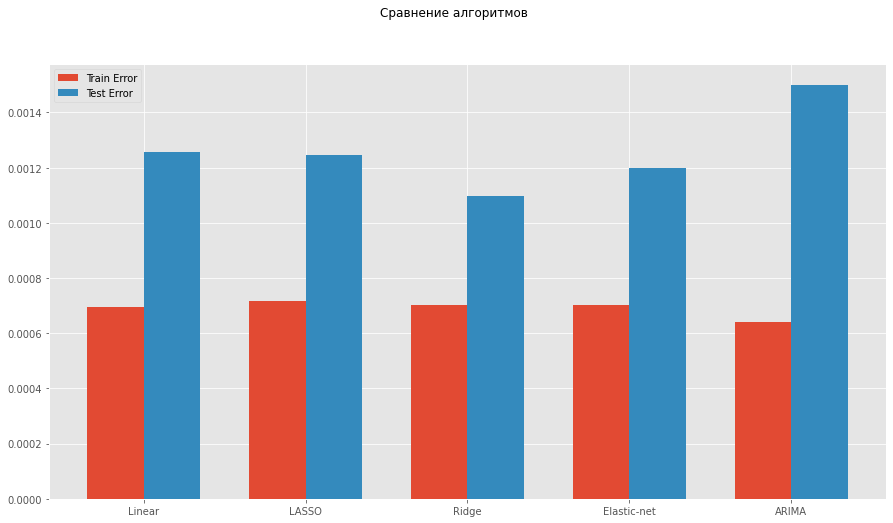

In [147]:
# compare algorithms
fig = plt.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Сравнение алгоритмов')
ax = fig.add_subplot(111)
plt.bar(ind - width/2, train_results,  width=width, label='Train Error')
plt.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
plt.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
plt.show()